In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys
sys.path.append('./zdrojaky')
from tsplot import tsplot
from statsmodels import tsa
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.api import qqplot
from IPython.display import display, Markdown
from statsmodels.tsa.seasonal import seasonal_decompose

# Four-weekly totals of beer shipments
Čtyřtýdení součty objednávek piva. Rok neznámý, proto jako pravděpodobný rok byl zvolen rok 1970.

In [3]:
df = pd.read_csv('fourweekly-totals-of-beer-shipme.csv')
df.info()

fn = 'fourweekly-totals-of-beer-shipme.csv'
# Vyberu z datasetu pouze součtu objednávek v jednotlivých týdnech
data = df['Four-weekly totals of beer shipments'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
Week                                    52 non-null object
Four-weekly totals of beer shipments    52 non-null int64
dtypes: int64(1), object(1)
memory usage: 912.0+ bytes


### Vizualizace dat

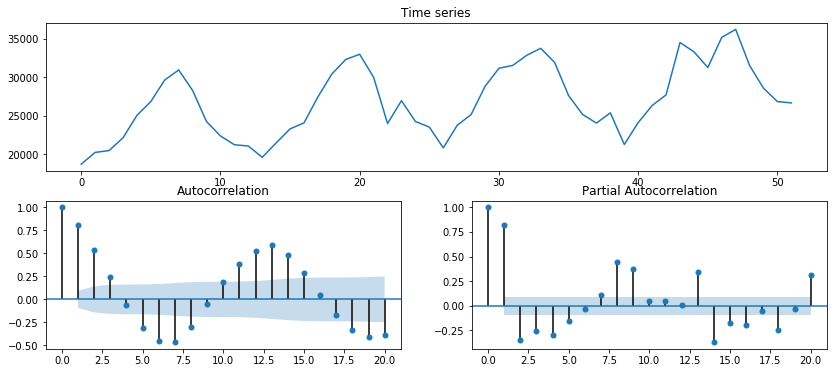

In [4]:
tsplot(data)
display(Markdown('### Vizualizace dat'))

Časová řada představuje prodeje piva za 4 roky vždy po čtyřtýdenních součtech.
Při pohledu na časovou řadu je patrná sezónost, která se dala očekávat.
Nárůst objednávek přes letní měsíce, kdy se určitě více pije pivo.

Dále méně patrný je trend. V těchto 4 letech počet objednávek narůstal.
Může být výhodné si vyzkoušet řadu dekomponovat na trend, sezónost a šum.

Z vizualizace je také patrná perioda, která je 13 (52/4). Časová preioda je tedy 1 rok, ale v datech je 13, protože jsou to čtyřtýdenní součty objednávek.

### Dekompozice na trend, sezónost a šum

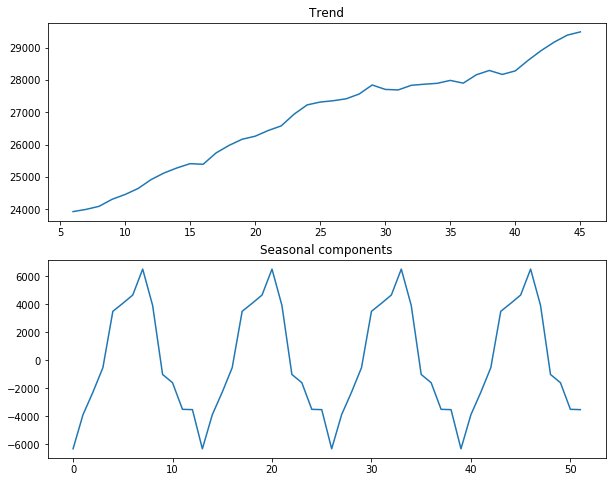

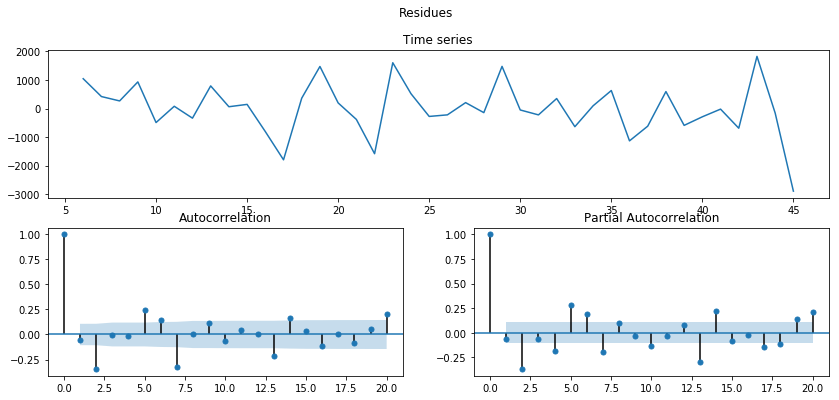

In [5]:
result = seasonal_decompose(df['Four-weekly totals of beer shipments'], freq=13, model='aditive')
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(result.trend)
plt.title("Trend")
plt.subplot(2,1,2)
plt.plot(result.seasonal)
plt.title("Seasonal components")
tsplot(result.resid.dropna())
plt.suptitle("Residues")
plt.show()

Zde je vidět patrný předpokládaný trend a sezónost. V reziduích však mohou stále zůstavát některé nevysvětlené části. 

Budu se snažit na řadu nafitovat model, který podle zvolím SARIMAX se sezónou popsanou výše. S jednou differencí pro sezóní paramentry.

### Výběr modelu

/home/ladislav/MI-SCR/__venv__/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                   52
Model:             SARIMAX(0, 1, 0, 13)   Log Likelihood                -359.472
Date:                  Wed, 19 Dec 2018   AIC                            720.943
Time:                          13:28:16   BIC                            722.607
Sample:                               0   HQIC                           721.540
                                   - 52                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.859e+06   1.83e+06      3.197      0.001    2.27e+06    9.45e+06
Ljung-Box (Q):                       38.12   Jarque-Bera (JB):                 0.76
Prob(Q):                       

<Figure size 1080x216 with 0 Axes>

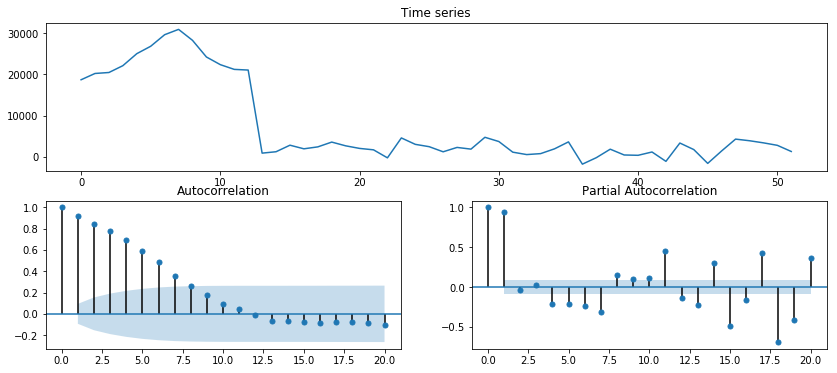

In [6]:
model = SARIMAX(data, order=(0,0,0), seasonal_order=(0,1,0,13))
result = model.fit()
print(result.summary())
plt.figure(figsize=(15,3))
tsplot(result.resid)
plt.show()

Z PACF je ještě stále vysoký první peak, který může signalizovat AR složku nebo poddifferencovanost modelu. 

Podle toho jak je velmi vysoký, proto v modelu zvýším differenci o 1. 
(Při vyzkoušení navýšení koeficientu AR, 
 vyšla pro první parametr p-hondota rovna nule tedy staticsticky významná, 
 ale v reziduích zůstal v PACF stále velký první peak. Také se zvýšila hodnota BIC a AIC)

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   52
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 13)   Log Likelihood                -343.405
Date:                            Wed, 19 Dec 2018   AIC                            688.811
Time:                                    13:28:18   BIC                            690.448
Sample:                                         0   HQIC                           689.393
                                             - 52                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.077e+06   8.21e+05      4.969      0.000    2.47e+06    5.69e+06
Ljung-Box (Q):                     

<Figure size 1080x216 with 0 Axes>

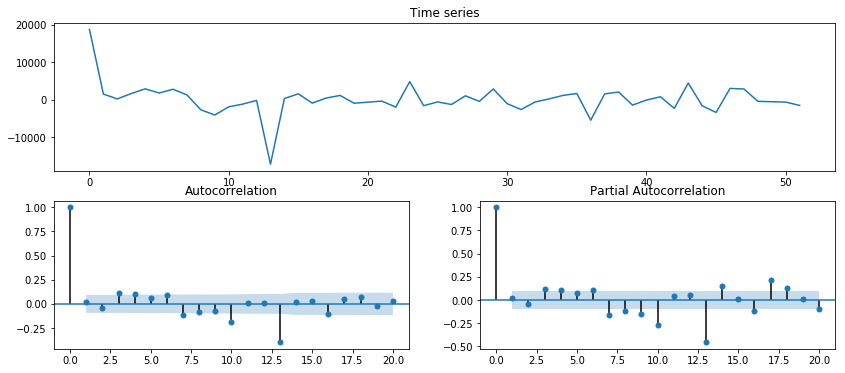

In [7]:
model = SARIMAX(data, order=(0,1,0), seasonal_order=(0,1,0,13))
result = model.fit()
print(result.summary())
plt.figure(figsize=(15,3))
tsplot(result.resid)
plt.show()

# Model bez diferencí pro porovnání histogramů
model_bad = SARIMAX(data, order=(0,0,0), seasonal_order=(0,1,0,13))
result_bad = model_bad.fit()

Jako nejlepší varianta se jevil model SARIMAX(0, 1, 0)x(0, 1, 0, 13). 

Pokud jsem zvýšil MA koeficient, tak podle statistického testu vyšel statisticky významě. AIC ani BIC se nezlepšila a ani podle ACF bych MA koeficient neočekával. Vždy je lepší volit jednoduší model, proto jsem tento koeficient nezvolil.

### Predikce

Dále jsem se pokusil vytvořit odhady budoucích hodnot pomocí předchozího modelu SARIMAX.
Dat není příliž mnoho, což ještě komplikuje předpovědi na větší časový úsek dopředu. Udělám poměrně dlouho predikci na 80 týdnů dobředu. To odpovídá více jak jednomu roku dopředu a je vidět obrovský interval spolehlivosti. 

Předpověď pro první rok vypadá dobře, ikdyž pás spolehlivosti je pořád poměrně velký.

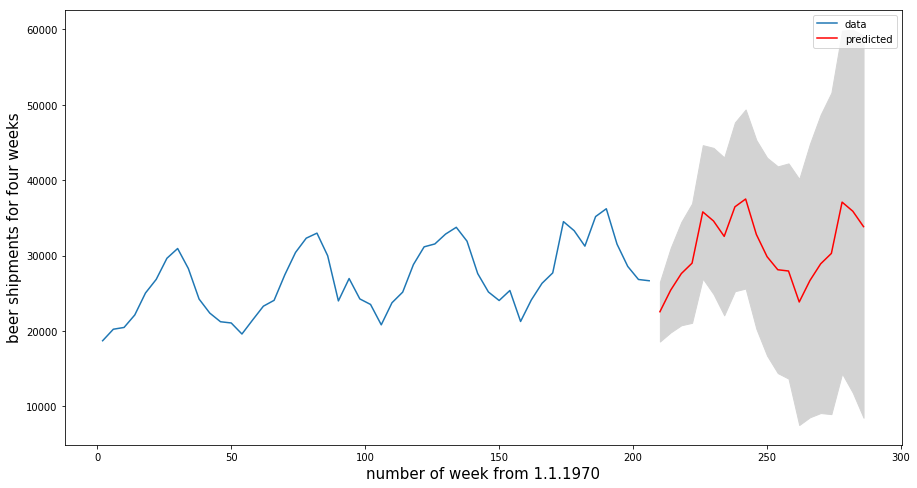

In [8]:
nsteps = 20
forecast = result.get_forecast(steps=nsteps)
plt.figure(figsize=(15,8))
plt.plot(np.arange(data.size)*4+2, data, label='data')

plt.plot(np.arange(data.size, data.size+forecast.predicted_mean.size)*4+2, 
         forecast.predicted_mean, 'r', label='predicted')

plt.fill_between(np.arange(data.size, data.size+forecast.predicted_mean.size)*4+2, 
                 forecast.summary_frame()['mean_ci_lower'],
                 forecast.summary_frame()['mean_ci_upper'],
                 color='lightgray')
plt.legend()
plt.xlabel('number of week from 1.1.1970', fontsize=15)
plt.ylabel('beer shipments for four weeks', fontsize=15)
plt.show()

### Histogram reziduí

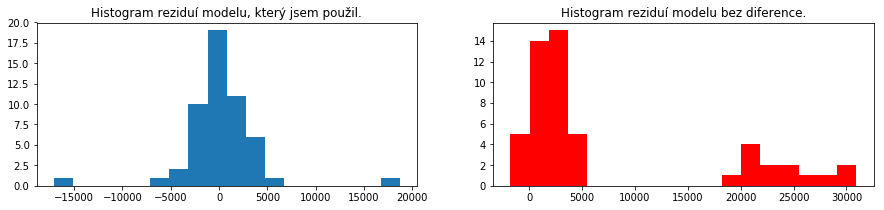

In [9]:
plt.figure(figsize=(15,3))
ax = plt.subplot(1,2,1)
plt.hist(result.resid, bins=18)
plt.title('Histogram reziduí modelu, který jsem použil.')
ax = plt.subplot(1,2,2)
plt.hist(result_bad.resid, bins=18, color='red')
plt.title('Histogram reziduí modelu bez diference.')
plt.show()

Když jsem si ještě vykreslil histogram reziduí, jsou patrné "heavy-tails" na normální distribuci. 
To může být způsobeno i nějakými nevysvětlenými daty v modelu, ale nejsou tak veliké. 

Vpravo jsem si vykreslil rezidua pro model bez diferencí, kde je vidět jejich problémové rozdělení, protože v nic stále očividně zůstavají informace a model nefunguje dobře.

Je vidět, že jinak mají rezidua normální rozdělení se středem v 0. 
Tedy v reziduích je již pouze šum, který by měl být centrovaný v nule.

### Zdroj dat
<https://datamarket.com/data/set/2325/four-weekly-totals-of-beer-shipments#!ds=2325&display=line>